Let's examine how a SimpleNN does. We extensively use the `AdaFNN_research` framework we developed and used last semester.

## Imports

In [1]:
from pathlib import Path
import statistics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import torch
from tqdm import tqdm
from xgboost import XGBRegressor

from tecatorfda.data import load_tecator_fat
from tecatorfda.pca_models import CustomPCA
import adafnnresearch as afr

## Load the data

In [2]:
# Define the data directory to save to.
project_root = Path.cwd().resolve().parent.parent
output_directory = project_root / "artifacts" / "original_data" / "09_simplenn"

# Define the data directory to read from.
data_location_directory = project_root / "data" / "original"
artifacts_location_directory = project_root / "artifacts" / "original_data"

# Load the data.
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat(
    location=data_location_directory
)

# Numpy arrays.
X = tecator_df.to_numpy()
y = fat_df.to_numpy().ravel()
t = np.array(wavelength_grid)

# Pandas DataFrames.
X_df = tecator_df
y_df = fat_df
t_df = pd.DataFrame(wavelength_grid).T

## Create results directories

In [3]:
output_directory_models = output_directory / "models"
output_directory_scores = output_directory / "scores"

output_directory_models.mkdir(parents=True, exist_ok=True)
output_directory_scores.mkdir(parents=True, exist_ok=True)

## Examinations

Define batch and split sizes.

In [4]:
batch_size = 32
split_custom = (0.64, 0.16, 0.20)

Define units.

In [5]:
t_units = "nm"
X_units = "Absorbance"
y_units = "%"

Create a DataLoader.

In [6]:
dataloader = afr.preprocessing.DataLoader(X_df,
                                          y_df,
                                          t_df,
                                          seed=0,
                                          split_proportions=split_custom,
                                          batch_size=batch_size,
                                          standardize_X=False,
                                          standardize_Y=False)

Plot the first 5 training functionals $X(t)$, along with their corresponding $y$-scores.

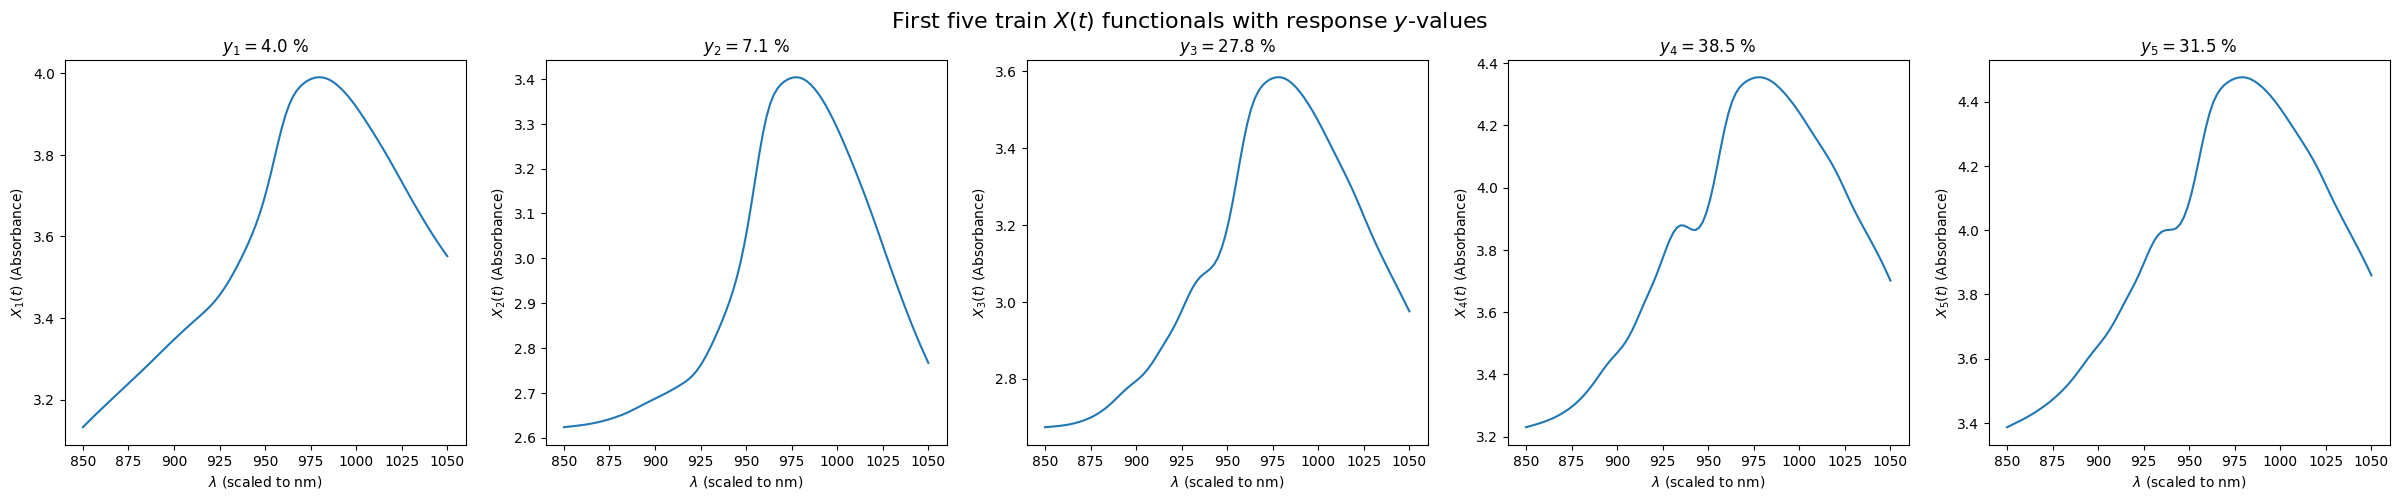

In [7]:
current_batch_gen = dataloader.get_train_batch()
current_batch_X, current_batch_Y = next(current_batch_gen)

fig, ax = plt.subplots(1, 5, figsize=(30, 5))
fig.suptitle("First five train $X(t)$ functionals with response $y$-values", fontsize=16)

for i in range(5):
    ax[i].plot(t, current_batch_X[i])
    ax[i].set_xlabel(fr"$\lambda$ (scaled to {t_units})")
    ax[i].set_ylabel(f"$X_{i+1}(t)$ ({X_units})")
    ax[i].set_title(f"$y_{i+1} = {round(current_batch_Y[i,0].item(), 4)}$ {y_units}")

plt.show()

# Analysis of vectorized data

We run linear regression, scikit-learn's MLPRegressor, and our custom SimpleNN on these data, all to convergence.

## Linear regression

Train MAE: 0.3913
Test MAE: 2.4566

Train MAPE: 0.0469
Test MAPE: 0.1656

Train MSE: 0.2704
Test MSE: 11.5324

Train R^2: 0.9983
Test R^2: 0.927



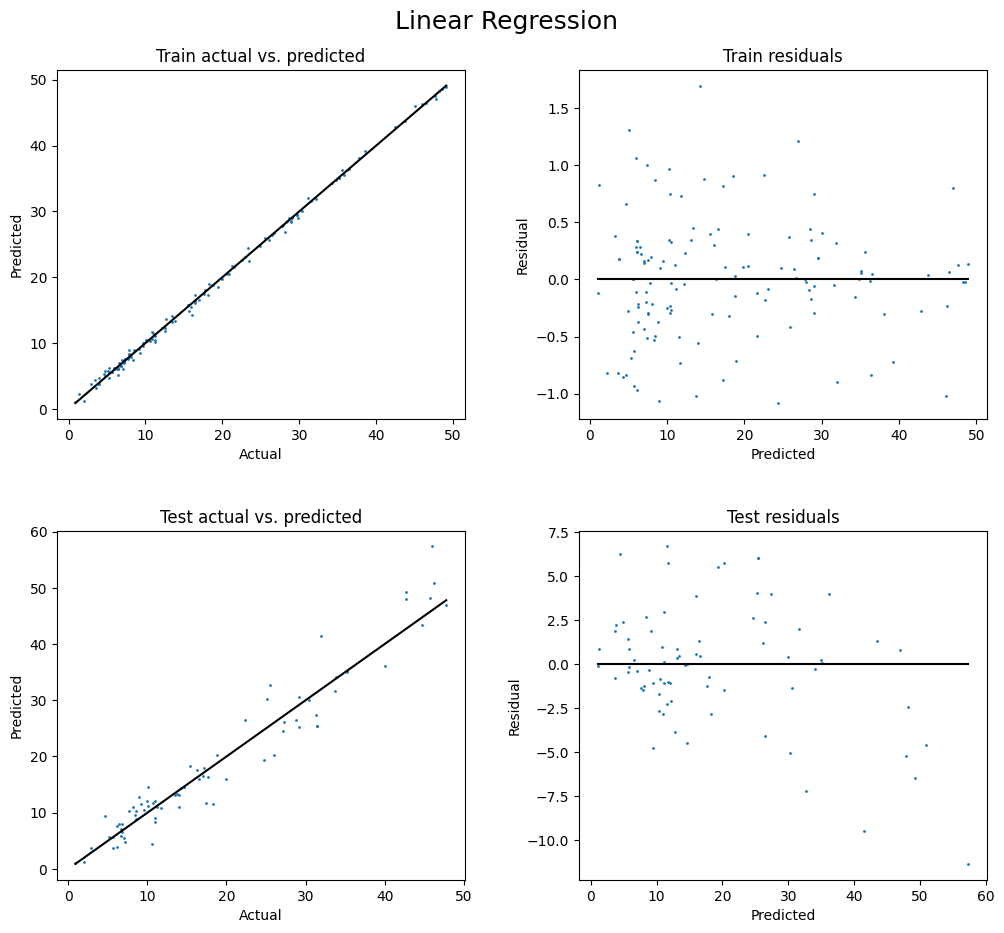

In [8]:
lr_vect_train_pred, lr_vect_valid_pred, lr_vect_test_pred, lr_vect_model = afr.sklearn.fit_and_predict_split(LinearRegression(), dataloader)
lr_vect_scores = afr.sklearn.show_useful_results("Linear Regression",
                                                 dataloader,
                                                 lr_vect_train_pred,
                                                 lr_vect_valid_pred,
                                                 lr_vect_test_pred)

## Scikit-learn MLP

In [9]:
MLPRegressor_layers = [50, 50]
optimizer_name = 'adam'
learning_rate = 0.000001
epochs = 5000
random_state = 0
early_stop = True
n_iter_no_change = 200

Train MAE: 9.8136
Test MAE: 9.6165

Train MAPE: 1.0546
Test MAPE: 0.9723

Train MSE: 135.5269
Test MSE: 140.6186

Train R^2: 0.1703
Test R^2: 0.1103



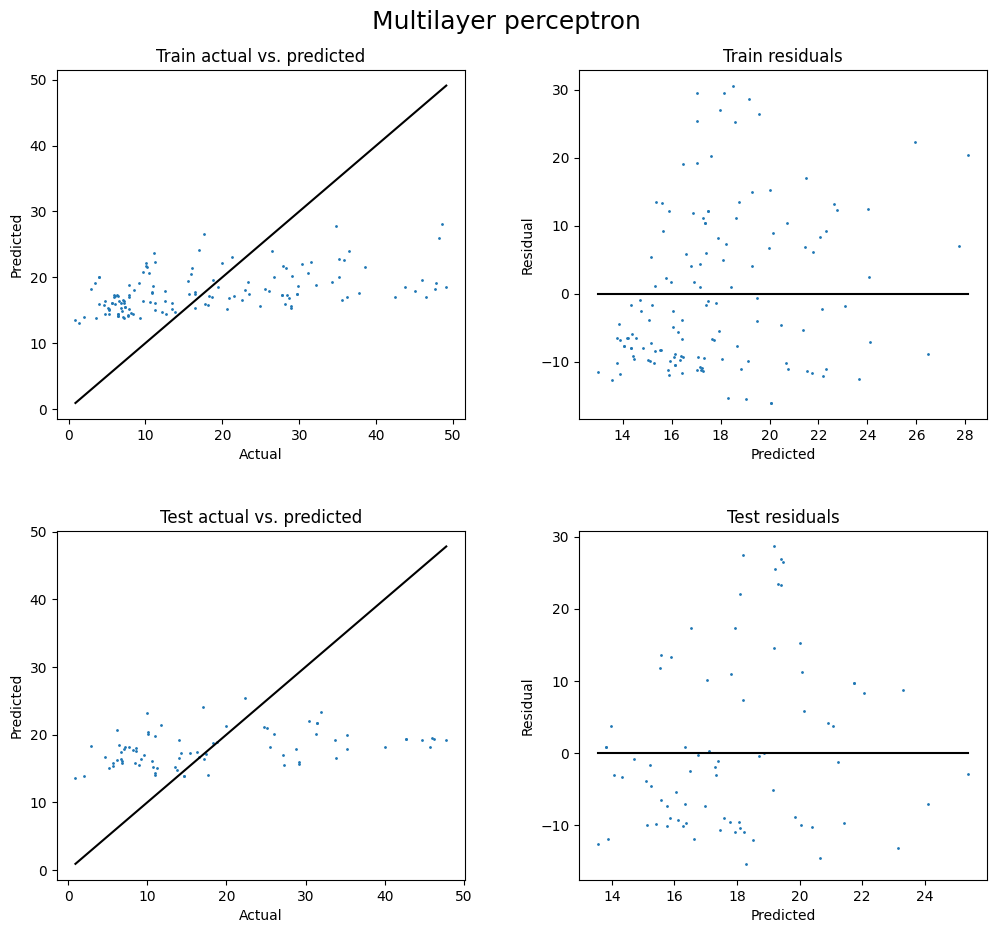

In [10]:
mlp_vect_model = MLPRegressor(hidden_layer_sizes=MLPRegressor_layers,
                              solver=optimizer_name,
                              batch_size=batch_size,
                              learning_rate_init=learning_rate,
                              max_iter=epochs,
                              random_state=random_state,
                              early_stopping=early_stop,
                              n_iter_no_change=n_iter_no_change)
mlp_vect_train_pred, mlp_vect_valid_pred, mlp_vect_test_pred, mlp_vect_model = afr.sklearn.fit_and_predict_split(mlp_vect_model, dataloader)
mlp_vect_scores = afr.sklearn.show_useful_results("Multilayer perceptron",
                                                 dataloader,
                                                 mlp_vect_train_pred,
                                                 mlp_vect_valid_pred,
                                                 mlp_vect_test_pred)

## Scikit-learn Random Forest

Train MAE: 2.5323
Test MAE: 6.1018

Train MAPE: 0.2174
Test MAPE: 0.5104

Train MSE: 11.7558
Test MSE: 56.9423

Train R^2: 0.928
Test R^2: 0.6397



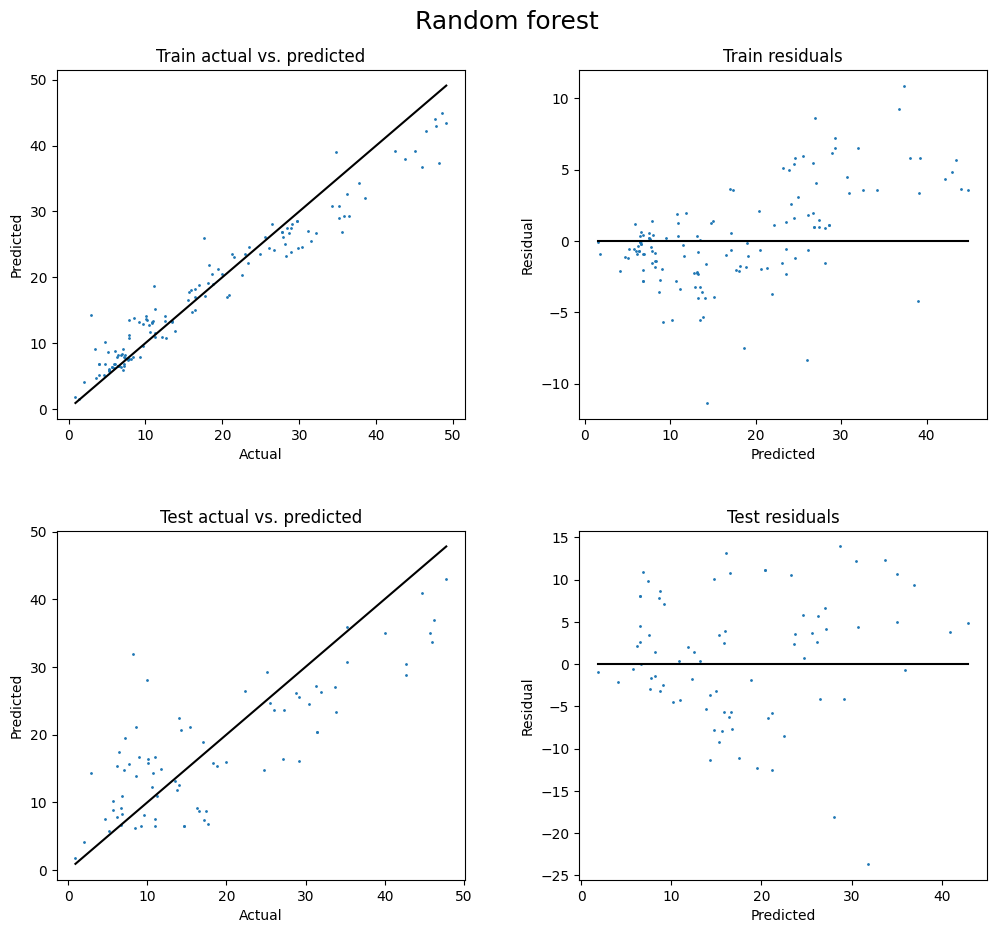

In [11]:
rf_vect_model = RandomForestRegressor(random_state=0)
rf_vect_train_pred, rf_vect_valid_pred, rf_vect_test_pred, rf_vect_model = afr.sklearn.fit_and_predict_split(rf_vect_model, dataloader)
rf_vect_scores = afr.sklearn.show_useful_results("Random forest",
                                                 dataloader,
                                                 rf_vect_train_pred,
                                                 rf_vect_valid_pred,
                                                 rf_vect_test_pred)

## XGBoost

Train MAE: 0.0011
Test MAE: 5.1194

Train MAPE: 0.0001
Test MAPE: 0.3913

Train MSE: 0.0
Test MSE: 49.7765

Train R^2: 1.0
Test R^2: 0.6851



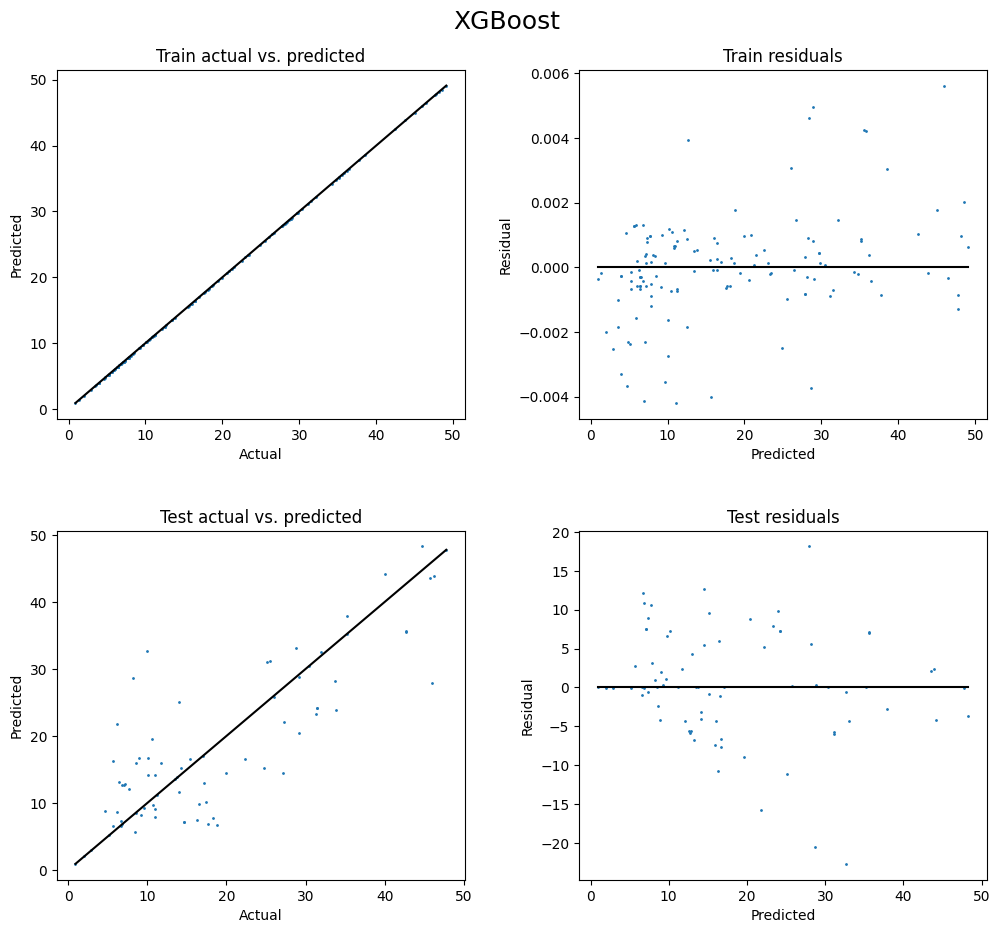

In [12]:
xgb_vect_model = XGBRegressor(random_state=0)
xgb_vect_train_pred, xgb_vect_valid_pred, xgb_vect_test_pred, xgb_vect_model = afr.sklearn.fit_and_predict_split(xgb_vect_model, dataloader)
xgb_vect_scores = afr.sklearn.show_useful_results("XGBoost",
                                                 dataloader,
                                                 xgb_vect_train_pred,
                                                 xgb_vect_valid_pred,
                                                 xgb_vect_test_pred)

## SimpleNN (without layer norm)

In [13]:
simpleNN_layers = [500, 500]
input_size = t.shape[0]
activation = torch.nn.functional.relu
dropout = 0.0
device = 'cpu'
optimizer_name = 'adam'
learning_rate = 0.0001
loss_fn = 'MSE'
seed = 0
layer_norm = False

num_epochs = None
to_convergence = True
verbose = True

In [14]:
# Define a SimpleNN.
simpleNN_no_ln_vect = afr.simplenn.SimpleNN(hidden_layers=simpleNN_layers,
                                      input_size=input_size,
                                      activation=activation,
                                      dropout=dropout,
                                      device=device,
                                      optimizer_name=optimizer_name,
                                      learning_rate=learning_rate,
                                      loss_fn=loss_fn,
                                      seed=seed,
                                      layer_norm=layer_norm)
# Fit.
simpleNN_no_ln_vect.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
simpleNN_no_ln_vect_train_pred = simpleNN_no_ln_vect.predict(data_loader=dataloader, dataset="train").numpy()
simpleNN_no_ln_vect_valid_pred = simpleNN_no_ln_vect.predict(data_loader=dataloader, dataset="valid").numpy()
simpleNN_no_ln_vect_test_pred = simpleNN_no_ln_vect.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 457.68218381561496. Validation loss: 464.4571515764509.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 414.2727267968393. Validation loss: 422.6642647879464.
Epoch 3 is best so far. Saved!
Epoch 3. Train loss: 375.3015729249829. Validation loss: 382.6471365792411.
Epoch 4 is best so far. Saved!
Epoch 4. Train loss: 337.70945706332685. Validation loss: 343.24566824776787.
Epoch 5 is best so far. Saved!
Epoch 5. Train loss: 301.17948200754876. Validation loss: 304.9053022112165.
Epoch 6 is best so far. Saved!
Epoch 6. Train loss: 266.16525157176665. Validation loss: 268.1437979561942.
Epoch 7 is best so far. Saved!
Epoch 7. Train loss: 233.12153881657733. Validation loss: 233.18333914620536.
Epoch 8 is best so far. Saved!
Epoch 8. Train loss: 202.89002199938696. Validation loss: 201.95936061314174.
Epoch 9 is best so far. Saved!
Epoch 9. Train loss: 177.3102958289376. Validation loss: 176.2143519810268.
Epoch 

Actual vs. predicted and residual plots.

Train MAE: 1.3794
Test MAE: 1.7099

Train MAPE: 0.2153
Test MAPE: 0.2434

Train MSE: 3.1278
Test MSE: 4.7227

Train R^2: 0.9809
Test R^2: 0.9701



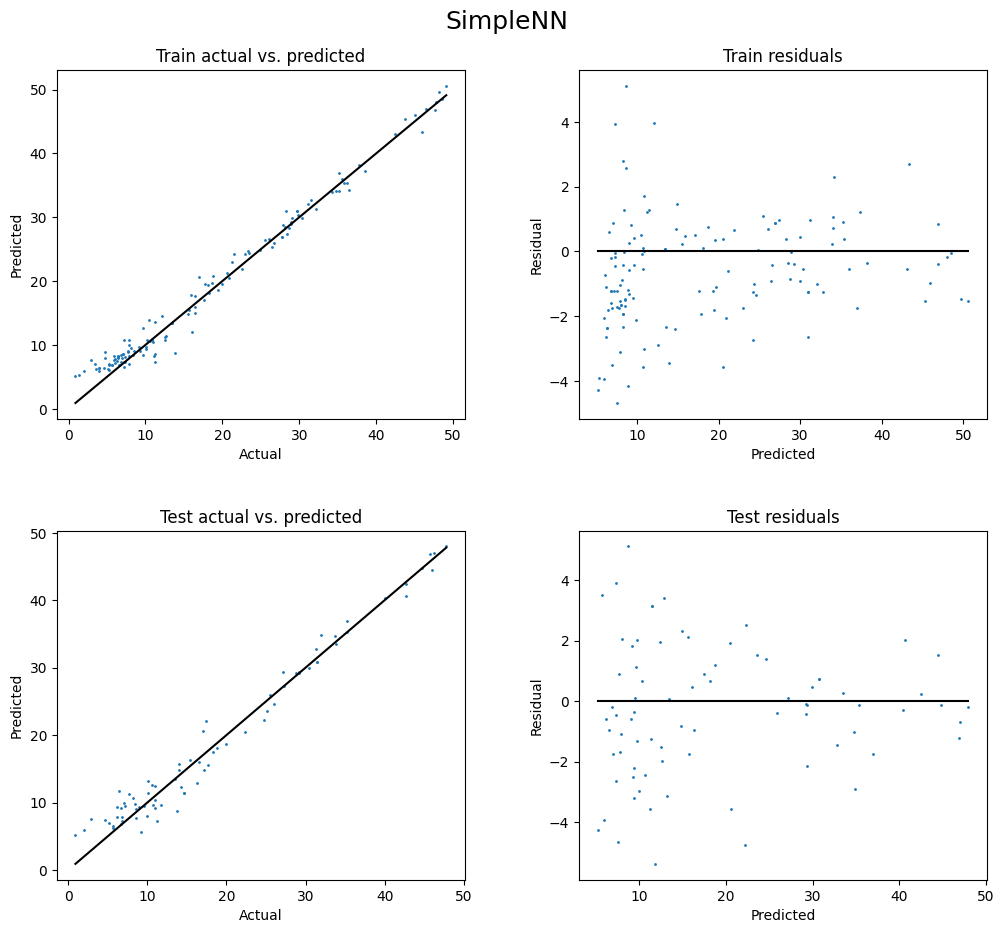

In [15]:
simpleNN_no_ln_vect_scores = afr.sklearn.show_useful_results("SimpleNN",
                                                             dataloader,
                                                             simpleNN_no_ln_vect_train_pred,
                                                             simpleNN_no_ln_vect_valid_pred,
                                                             simpleNN_no_ln_vect_test_pred)

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 9472
Train R^2: 0.9809
Train MSE: 3.1278493764936433
Valid R^2: 0.9632
Valid MSE: 5.860575849298228
Test R^2: 0.9758
Test MSE: 3.7964886583664974


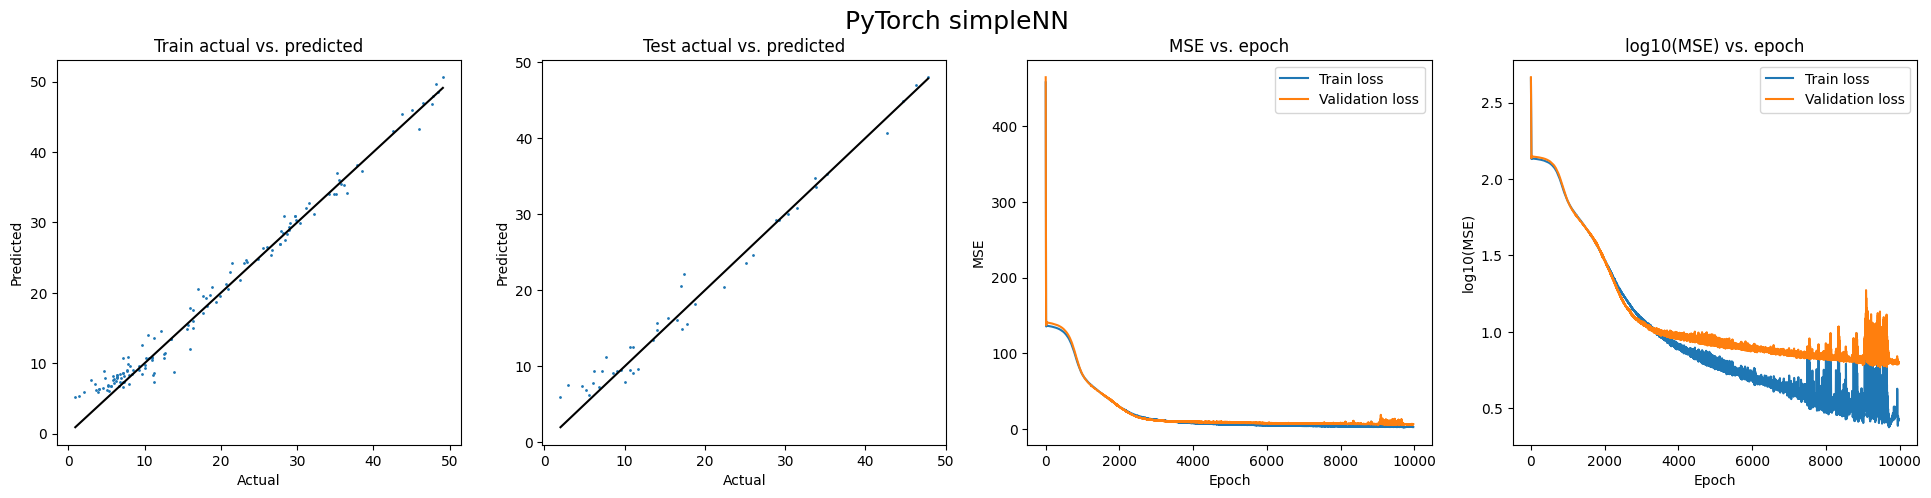

In [16]:
simpleNN_no_ln_vect.useful_plots(dataloader)

## SimpleNN (with layer norm)

In [17]:
simpleNN_layers = [25, 25]
input_size = t.shape[0]
activation = torch.nn.functional.relu
dropout = 0.0
device = 'cpu'
optimizer_name = 'adam'
learning_rate = 0.001
loss_fn = 'MSE'
seed = 0
layer_norm = True

num_epochs = None
to_convergence = True
verbose = True

In [18]:
# Define a SimpleNN.
simpleNN_ln_vect = afr.simplenn.SimpleNN(hidden_layers=simpleNN_layers,
                                      input_size=input_size,
                                      activation=activation,
                                      dropout=dropout,
                                      device=device,
                                      optimizer_name=optimizer_name,
                                      learning_rate=learning_rate,
                                      loss_fn=loss_fn,
                                      seed=seed,
                                      layer_norm=layer_norm)
# Fit.
simpleNN_ln_vect.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
simpleNN_ln_vect_train_pred = simpleNN_ln_vect.predict(data_loader=dataloader, dataset="train").numpy()
simpleNN_ln_vect_valid_pred = simpleNN_ln_vect.predict(data_loader=dataloader, dataset="valid").numpy()
simpleNN_ln_vect_test_pred = simpleNN_ln_vect.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 484.35042555314783. Validation loss: 497.1512329101562.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 455.1230444246834. Validation loss: 482.8836373465402.
Epoch 3 is best so far. Saved!
Epoch 3. Train loss: 441.8876899663549. Validation loss: 472.6558611188616.
Epoch 4 is best so far. Saved!
Epoch 4. Train loss: 432.3455179033488. Validation loss: 459.4289132254464.
Epoch 5 is best so far. Saved!
Epoch 5. Train loss: 417.76583706375453. Validation loss: 440.9597891671317.
Epoch 6 is best so far. Saved!
Epoch 6. Train loss: 399.38268319011604. Validation loss: 419.84709036690845.
Epoch 7 is best so far. Saved!
Epoch 7. Train loss: 378.2173131121336. Validation loss: 392.72753557477677.
Epoch 8 is best so far. Saved!
Epoch 8. Train loss: 350.5397654066991. Validation loss: 358.0631059919085.
Epoch 9 is best so far. Saved!
Epoch 9. Train loss: 315.38041776114136. Validation loss: 313.8795802525112.
Epoch 10 

Actual vs. predicted and residual plots.

Train MAE: 2.7331
Test MAE: 2.5818

Train MAPE: 0.4258
Test MAPE: 0.3701

Train MSE: 13.034
Test MSE: 11.7312

Train R^2: 0.9202
Test R^2: 0.9258



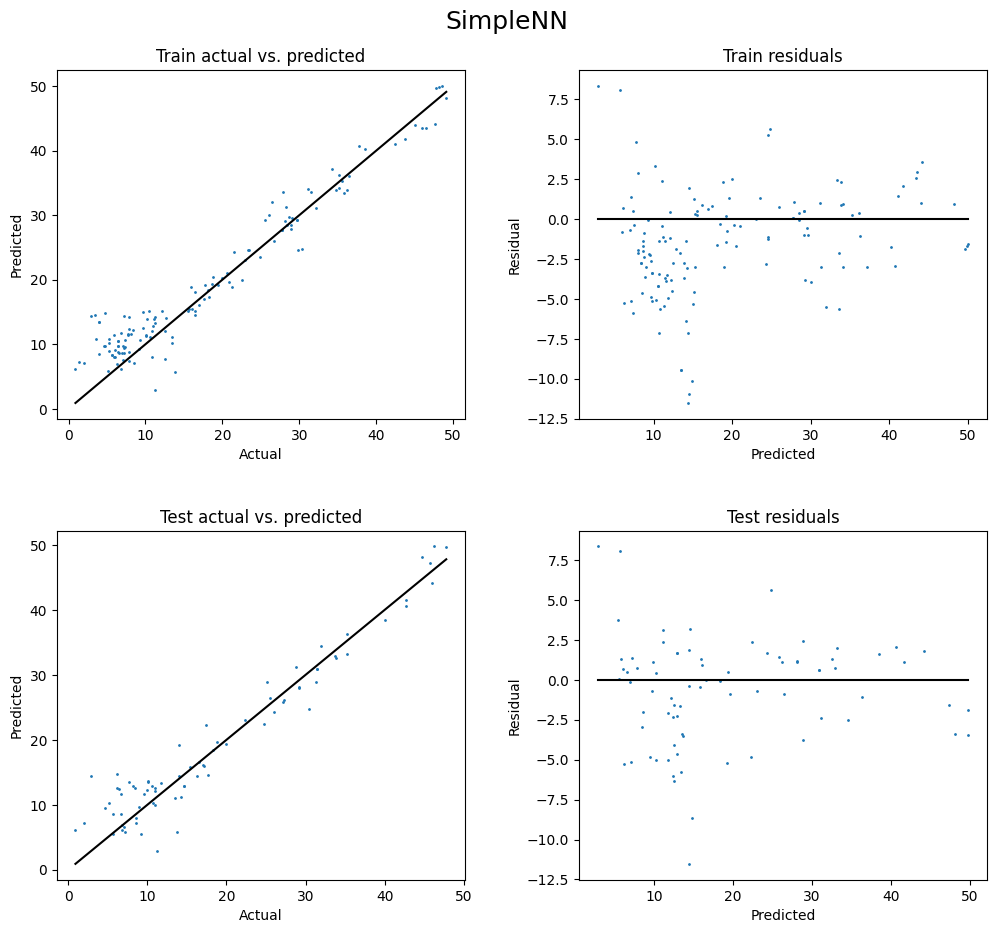

In [19]:
simpleNN_ln_vect_scores = afr.sklearn.show_useful_results("SimpleNN",
                                                 dataloader,
                                                 simpleNN_ln_vect_train_pred,
                                                 simpleNN_ln_vect_valid_pred,
                                                 simpleNN_ln_vect_test_pred)

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 1186
Train R^2: 0.9202
Train MSE: 13.033961190692304
Valid R^2: 0.9338
Valid MSE: 10.556738458112612
Test R^2: 0.919
Test MSE: 12.687190972227336


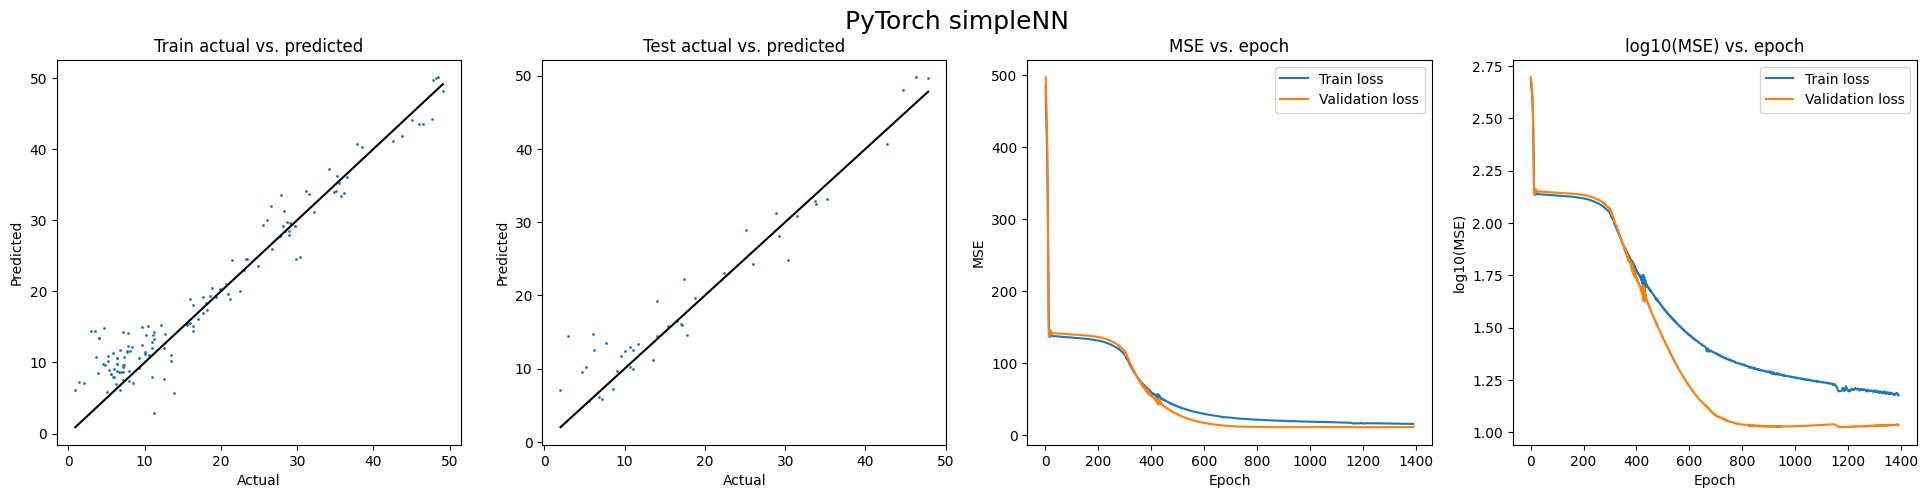

In [20]:
simpleNN_ln_vect.useful_plots(dataloader)

## Let's try another split

Define batch and split sizes.

In [21]:
batch_size = 32
split_custom = (0.64, 0.16, 0.20)

Define units.

In [22]:
t_units = "nm"
X_units = "Absorbance"
y_units = "%"

Create a DataLoader.

In [23]:
dataloader = afr.preprocessing.DataLoader(X_df,
                                          y_df,
                                          t_df,
                                          seed=1,
                                          split_proportions=split_custom,
                                          batch_size=batch_size,
                                          standardize_X=False,
                                          standardize_Y=False)

Plot the first 5 training functionals $X(t)$, along with their corresponding $y$-scores.

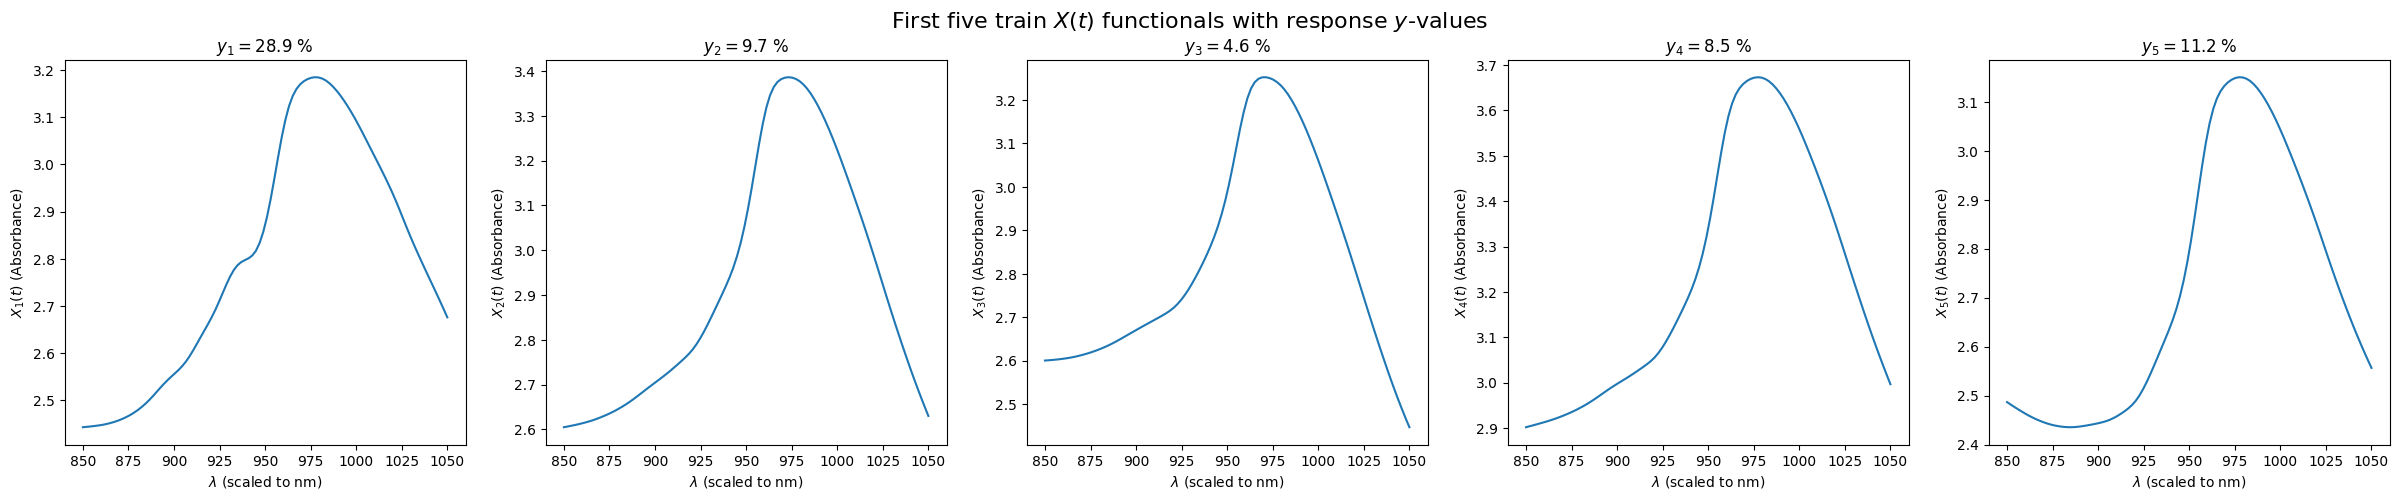

In [24]:
current_batch_gen = dataloader.get_train_batch()
current_batch_X, current_batch_Y = next(current_batch_gen)

fig, ax = plt.subplots(1, 5, figsize=(30, 5))
fig.suptitle("First five train $X(t)$ functionals with response $y$-values", fontsize=16)

for i in range(5):
    ax[i].plot(t, current_batch_X[i])
    ax[i].set_xlabel(fr"$\lambda$ (scaled to {t_units})")
    ax[i].set_ylabel(f"$X_{i+1}(t)$ ({X_units})")
    ax[i].set_title(f"$y_{i+1} = {round(current_batch_Y[i,0].item(), 4)}$ {y_units}")

plt.show()

# Analysis of vectorized data

We run linear regression, scikit-learn's MLPRegressor, and our custom SimpleNN on these data, all to convergence.

## Linear regression

Train MAE: 0.3928
Test MAE: 3.1624

Train MAPE: 0.0447
Test MAPE: 0.2304

Train MSE: 0.2746
Test MSE: 32.5283

Train R^2: 0.9983
Test R^2: 0.7833



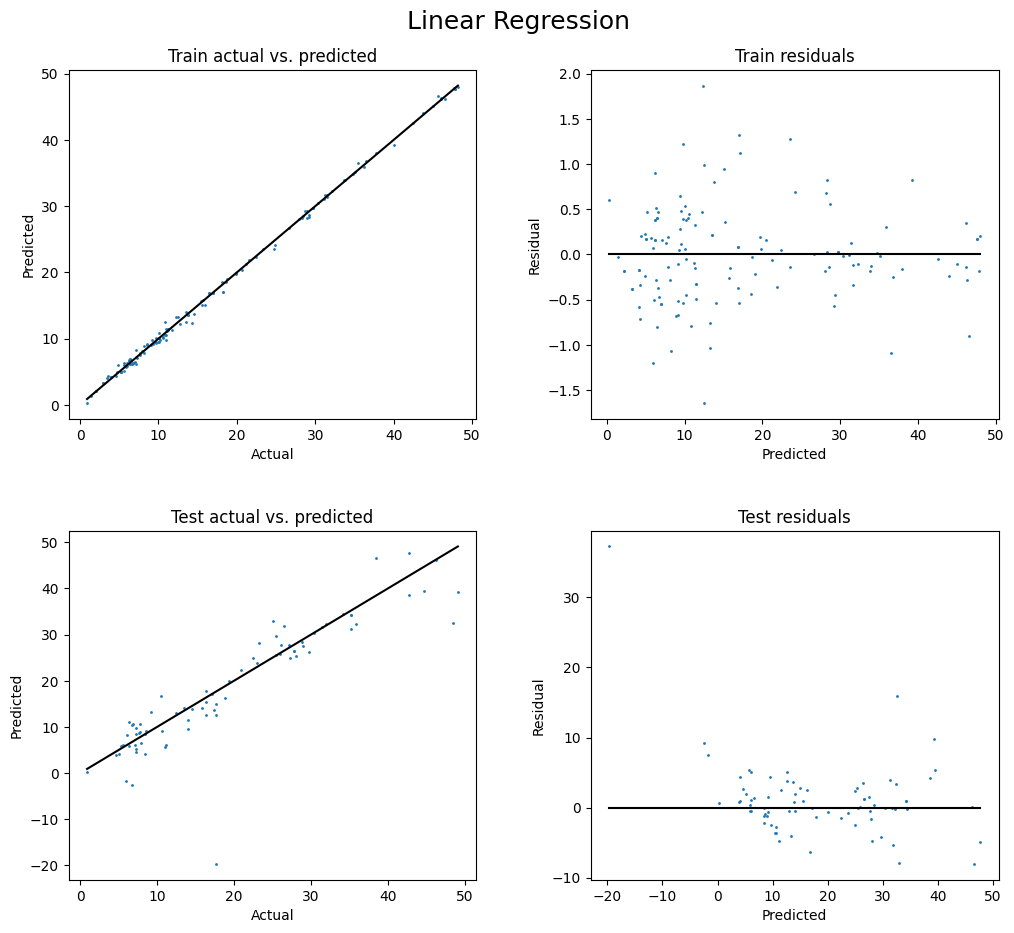

In [25]:
lr_vect_train_pred, lr_vect_valid_pred, lr_vect_test_pred, lr_vect_model = afr.sklearn.fit_and_predict_split(LinearRegression(), dataloader)
lr_vect_scores = afr.sklearn.show_useful_results("Linear Regression",
                                                 dataloader,
                                                 lr_vect_train_pred,
                                                 lr_vect_valid_pred,
                                                 lr_vect_test_pred)

## Scikit-learn MLP

In [26]:
MLPRegressor_layers = [50, 50]
optimizer_name = 'adam'
learning_rate = 0.000001
epochs = 5000
random_state = 0
early_stop = True
n_iter_no_change = 200

Train MAE: 9.6456
Test MAE: 9.3803

Train MAPE: 0.9678
Test MAPE: 0.7352

Train MSE: 150.8278
Test MSE: 136.5431

Train R^2: 0.0934
Test R^2: 0.0902



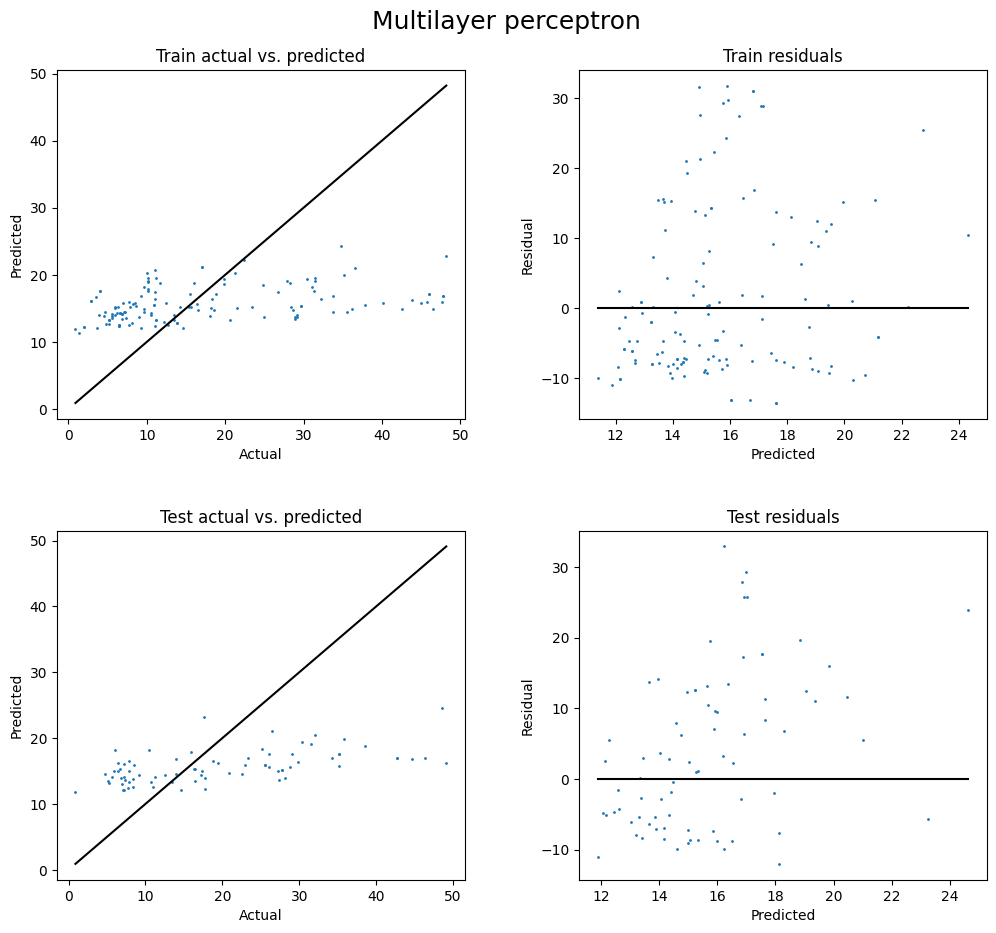

In [27]:
mlp_vect_model = MLPRegressor(hidden_layer_sizes=MLPRegressor_layers,
                              solver=optimizer_name,
                              batch_size=batch_size,
                              learning_rate_init=learning_rate,
                              max_iter=epochs,
                              random_state=random_state,
                              early_stopping=early_stop,
                              n_iter_no_change=n_iter_no_change)
mlp_vect_train_pred, mlp_vect_valid_pred, mlp_vect_test_pred, mlp_vect_model = afr.sklearn.fit_and_predict_split(mlp_vect_model, dataloader)
mlp_vect_scores = afr.sklearn.show_useful_results("Multilayer perceptron",
                                                 dataloader,
                                                 mlp_vect_train_pred,
                                                 mlp_vect_valid_pred,
                                                 mlp_vect_test_pred)

## Scikit-learn Random Forest

Train MAE: 2.3456
Test MAE: 5.1734

Train MAPE: 0.2227
Test MAPE: 0.3848

Train MSE: 9.6732
Test MSE: 45.5668

Train R^2: 0.9419
Test R^2: 0.6964



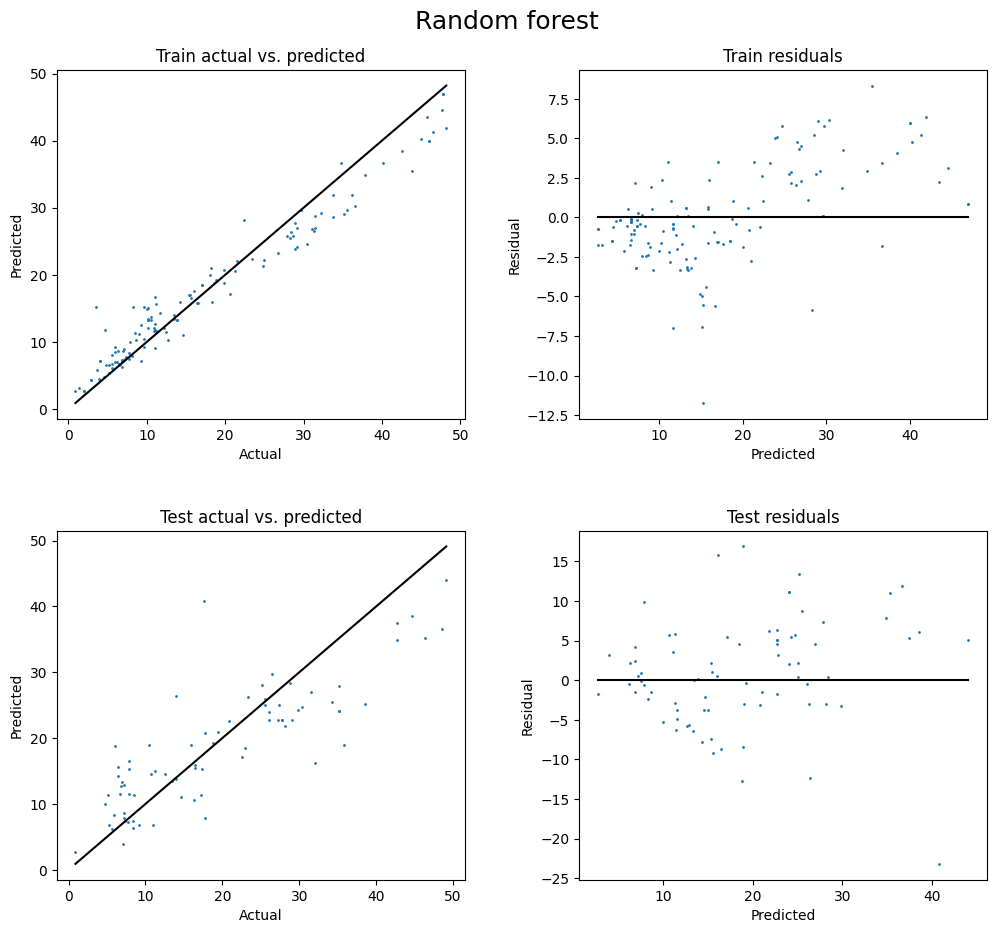

In [28]:
rf_vect_model = RandomForestRegressor(random_state=0)
rf_vect_train_pred, rf_vect_valid_pred, rf_vect_test_pred, rf_vect_model = afr.sklearn.fit_and_predict_split(rf_vect_model, dataloader)
rf_vect_scores = afr.sklearn.show_useful_results("Random forest",
                                                 dataloader,
                                                 rf_vect_train_pred,
                                                 rf_vect_valid_pred,
                                                 rf_vect_test_pred)

## XGBoost

Train MAE: 0.0027
Test MAE: 5.1801

Train MAPE: 0.0003
Test MAPE: 0.3603

Train MSE: 0.0
Test MSE: 53.7594

Train R^2: 1.0
Test R^2: 0.6418



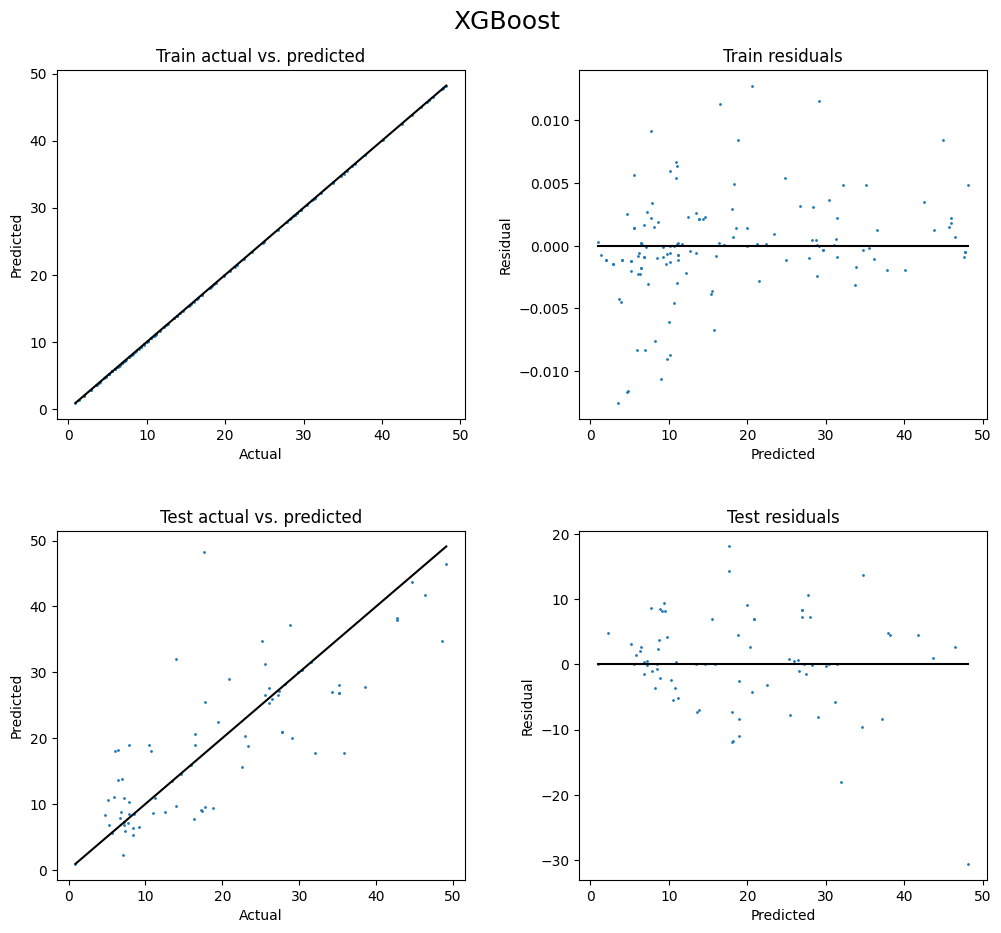

In [29]:
xgb_vect_model = XGBRegressor(random_state=0)
xgb_vect_train_pred, xgb_vect_valid_pred, xgb_vect_test_pred, xgb_vect_model = afr.sklearn.fit_and_predict_split(xgb_vect_model, dataloader)
xgb_vect_scores = afr.sklearn.show_useful_results("XGBoost",
                                                 dataloader,
                                                 xgb_vect_train_pred,
                                                 xgb_vect_valid_pred,
                                                 xgb_vect_test_pred)

## SimpleNN (without layer norm)

In [30]:
simpleNN_layers = [500, 500]
input_size = t.shape[0]
activation = torch.nn.functional.relu
dropout = 0.0
device = 'cpu'
optimizer_name = 'adam'
learning_rate = 0.0001
loss_fn = 'MSE'
seed = 0
layer_norm = False

num_epochs = None
to_convergence = True
verbose = True

In [31]:
# Define a SimpleNN.
simpleNN_no_ln_vect = afr.simplenn.SimpleNN(hidden_layers=simpleNN_layers,
                                      input_size=input_size,
                                      activation=activation,
                                      dropout=dropout,
                                      device=device,
                                      optimizer_name=optimizer_name,
                                      learning_rate=learning_rate,
                                      loss_fn=loss_fn,
                                      seed=seed,
                                      layer_norm=layer_norm)
# Fit.
simpleNN_no_ln_vect.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
simpleNN_no_ln_vect_train_pred = simpleNN_no_ln_vect.predict(data_loader=dataloader, dataset="train").numpy()
simpleNN_no_ln_vect_valid_pred = simpleNN_no_ln_vect.predict(data_loader=dataloader, dataset="valid").numpy()
simpleNN_no_ln_vect_test_pred = simpleNN_no_ln_vect.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 441.8718667134752. Validation loss: 573.4379403250558.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 400.3881550809763. Validation loss: 523.3743816920689.
Epoch 3 is best so far. Saved!
Epoch 3. Train loss: 363.29575141851046. Validation loss: 474.4542385646275.
Epoch 4 is best so far. Saved!
Epoch 4. Train loss: 327.2255378221943. Validation loss: 425.8320494515555.
Epoch 5 is best so far. Saved!
Epoch 5. Train loss: 292.3574294487055. Validation loss: 378.0351149967738.
Epoch 6 is best so far. Saved!
Epoch 6. Train loss: 259.14755271299043. Validation loss: 331.42414174761086.
Epoch 7 is best so far. Saved!
Epoch 7. Train loss: 227.9807536549812. Validation loss: 286.00969047546386.
Epoch 8 is best so far. Saved!
Epoch 8. Train loss: 199.8190349940836. Validation loss: 244.24202701023646.
Epoch 9 is best so far. Saved!
Epoch 9. Train loss: 176.5840995398751. Validation loss: 208.21608178274974.
Epoch 10 

Actual vs. predicted and residual plots.

Train MAE: 1.3039
Test MAE: 1.5253

Train MAPE: 0.2107
Test MAPE: 0.169

Train MSE: 3.0992
Test MSE: 3.772

Train R^2: 0.9814
Test R^2: 0.9749



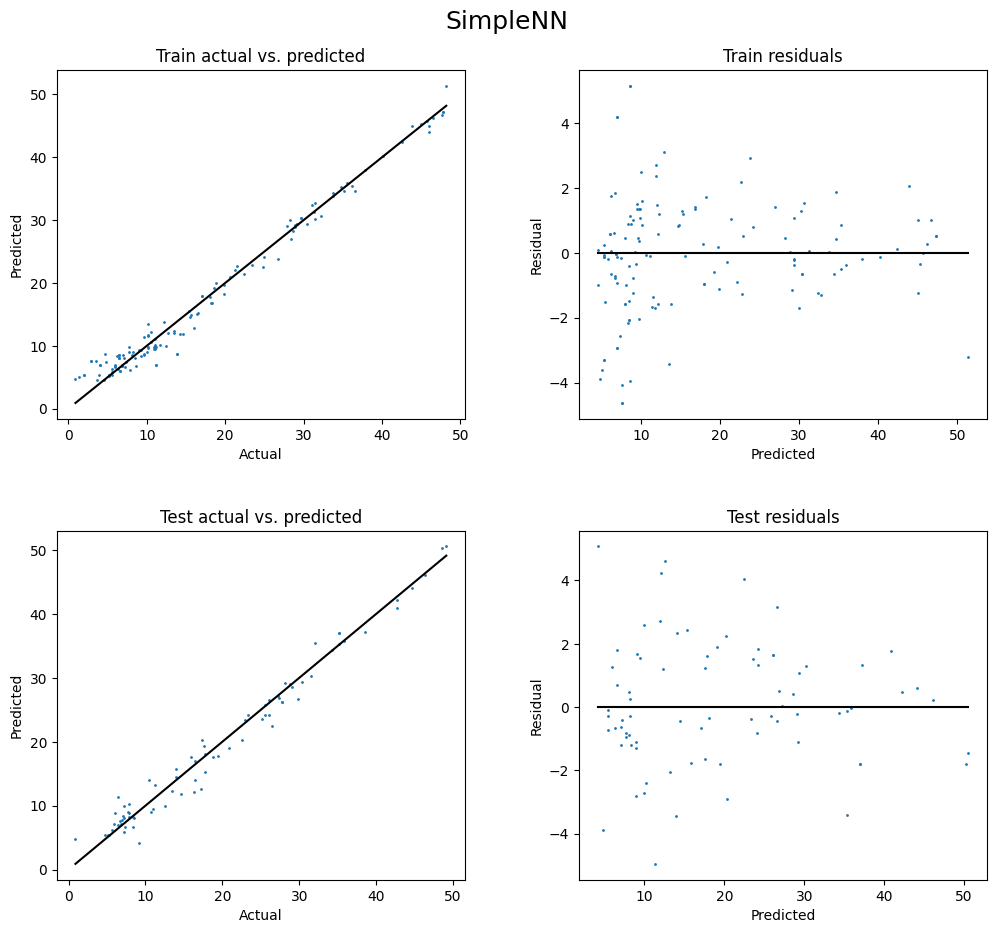

In [32]:
simpleNN_no_ln_vect_scores = afr.sklearn.show_useful_results("SimpleNN",
                                                             dataloader,
                                                             simpleNN_no_ln_vect_train_pred,
                                                             simpleNN_no_ln_vect_valid_pred,
                                                             simpleNN_no_ln_vect_test_pred)

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 7078
Train R^2: 0.9814
Train MSE: 3.0992289977473333
Valid R^2: 0.9821
Valid MSE: 3.298761803564546
Test R^2: 0.9644
Test MSE: 4.157155347296191


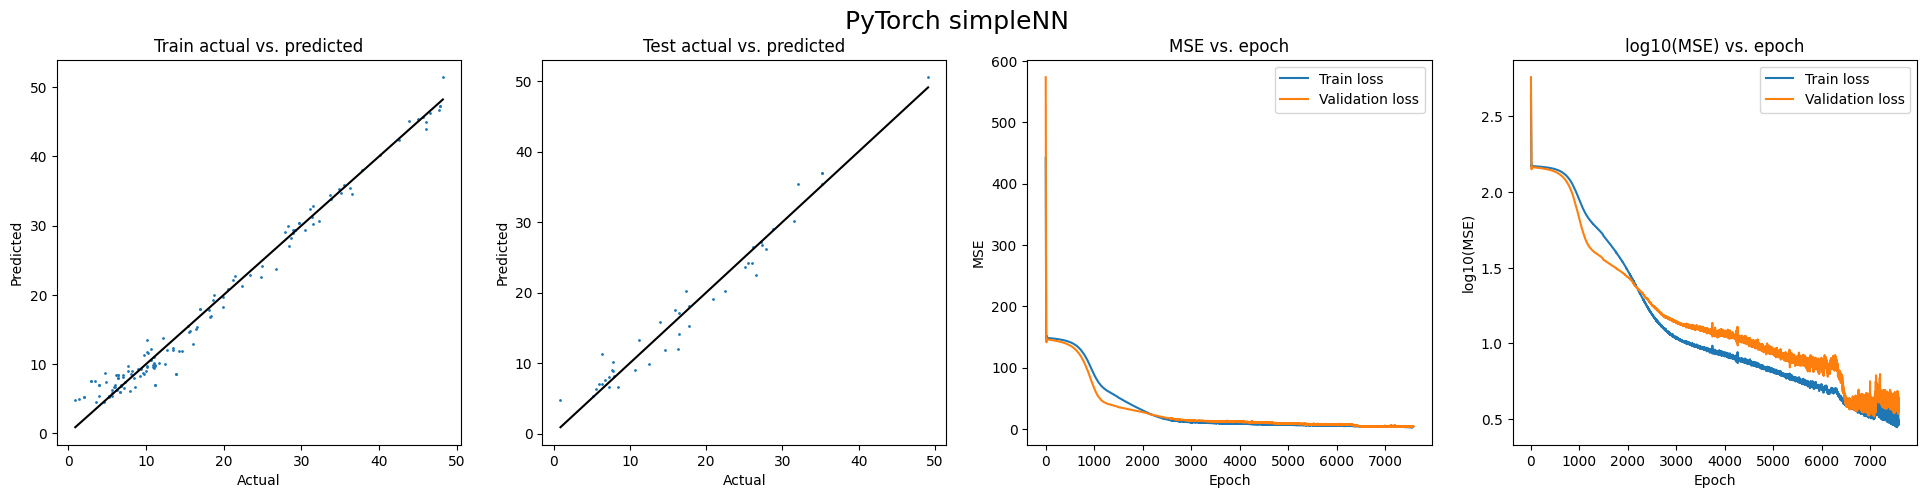

In [33]:
simpleNN_no_ln_vect.useful_plots(dataloader)

## SimpleNN (with layer norm)

In [34]:
simpleNN_layers = [500, 500]
input_size = t.shape[0]
activation = torch.nn.functional.relu
dropout = 0.0
device = 'cpu'
optimizer_name = 'adam'
learning_rate = 0.0001
loss_fn = 'MSE'
seed = 0
layer_norm = True

num_epochs = None
to_convergence = True
verbose = True

In [35]:
# Define a SimpleNN.
simpleNN_ln_vect = afr.simplenn.SimpleNN(hidden_layers=simpleNN_layers,
                                      input_size=input_size,
                                      activation=activation,
                                      dropout=dropout,
                                      device=device,
                                      optimizer_name=optimizer_name,
                                      learning_rate=learning_rate,
                                      loss_fn=loss_fn,
                                      seed=seed,
                                      layer_norm=layer_norm)
# Fit.
simpleNN_ln_vect.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
simpleNN_ln_vect_train_pred = simpleNN_ln_vect.predict(data_loader=dataloader, dataset="train").numpy()
simpleNN_ln_vect_valid_pred = simpleNN_ln_vect.predict(data_loader=dataloader, dataset="valid").numpy()
simpleNN_ln_vect_test_pred = simpleNN_ln_vect.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 455.126674234432. Validation loss: 573.7436525617327.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 394.0505883432653. Validation loss: 503.49310945783344.
Epoch 3 is best so far. Saved!
Epoch 3. Train loss: 343.6092275354984. Validation loss: 444.41246316092355.
Epoch 4 is best so far. Saved!
Epoch 4. Train loss: 301.7797994126368. Validation loss: 394.55398172651013.
Epoch 5 is best so far. Saved!
Epoch 5. Train loss: 268.1841896224196. Validation loss: 354.27440076555524.
Epoch 6 is best so far. Saved!
Epoch 6. Train loss: 241.54239693523326. Validation loss: 319.10601874760215.
Epoch 7 is best so far. Saved!
Epoch 7. Train loss: 219.04051420114337. Validation loss: 287.0924821853638.
Epoch 8 is best so far. Saved!
Epoch 8. Train loss: 199.57739369190523. Validation loss: 257.0903506142752.
Epoch 9 is best so far. Saved!
Epoch 9. Train loss: 182.5861526823392. Validation loss: 228.68214247567315.
Epoch 1

Actual vs. predicted and residual plots.

Train MAE: 2.7121
Test MAE: 2.4262

Train MAPE: 0.3587
Test MAPE: 0.2135

Train MSE: 15.0
Test MSE: 10.6252

Train R^2: 0.9098
Test R^2: 0.9292



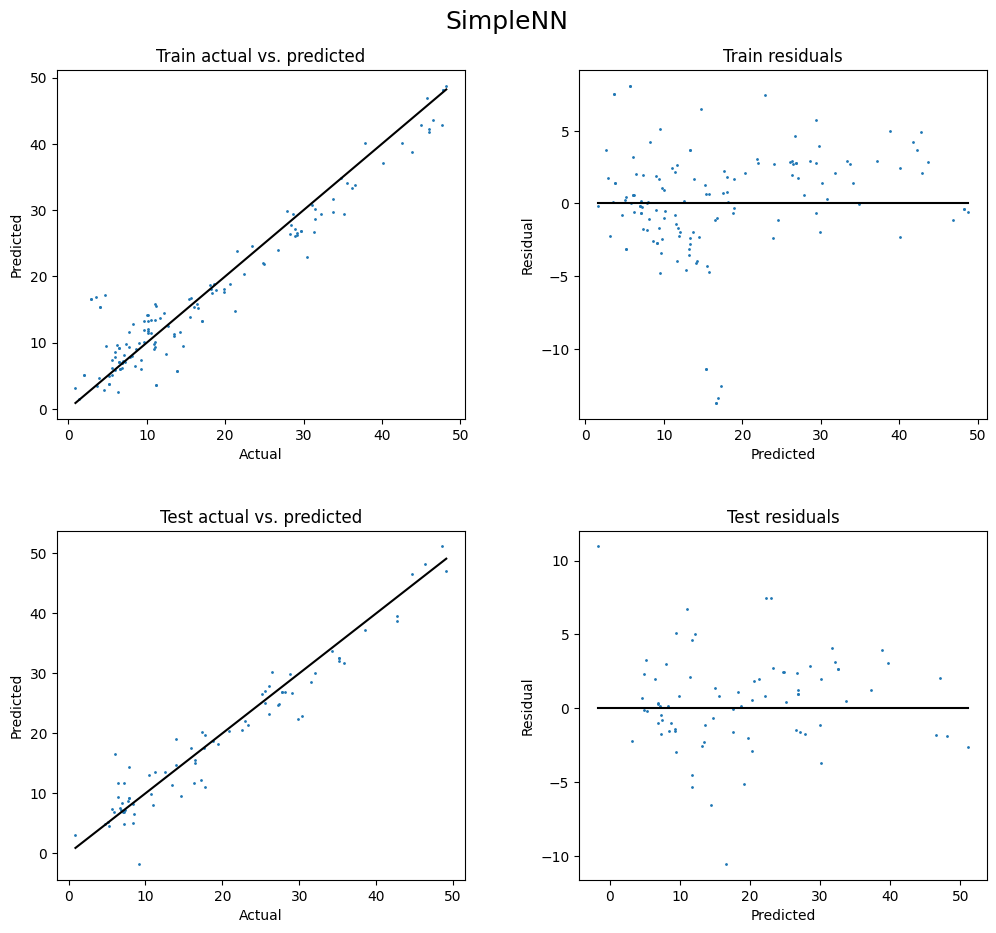

In [36]:
simpleNN_ln_vect_scores = afr.sklearn.show_useful_results("SimpleNN",
                                                 dataloader,
                                                 simpleNN_ln_vect_train_pred,
                                                 simpleNN_ln_vect_valid_pred,
                                                 simpleNN_ln_vect_test_pred)

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 652
Train R^2: 0.9098
Train MSE: 15.000007449705832
Valid R^2: 0.9235
Valid MSE: 14.114086426724157
Test R^2: 0.9333
Test MSE: 7.785346207332799


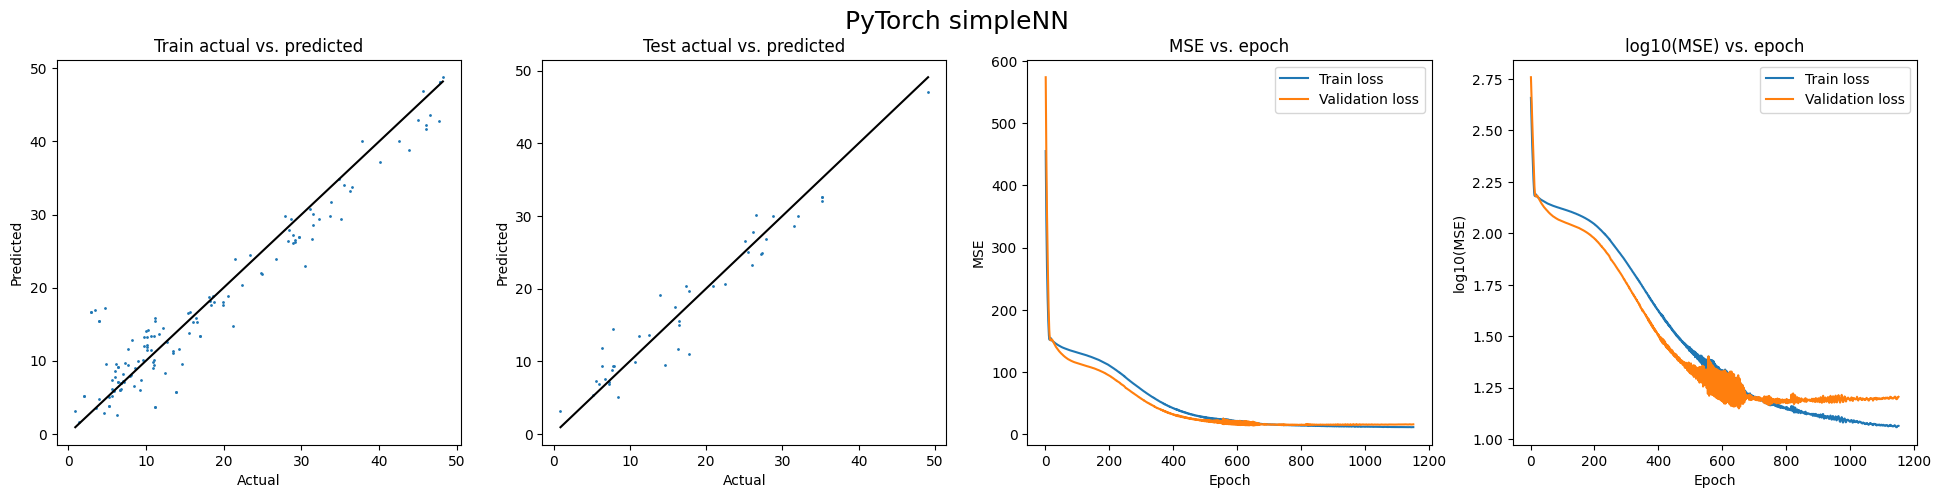

In [37]:
simpleNN_ln_vect.useful_plots(dataloader)

## 10-repeated 10-fold CV

In [38]:
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

### Verify that this matches the OLS case from test 01

In [39]:
n_splits = 10
n_repeats = 10

cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)

r2_scores = []
fold_info = []

fold_id = 0

batch_size = 32

for train_idx, test_idx in tqdm(cv.split(X), total=n_splits*n_repeats):
    fold_id += 1

    # Split the data.
    X_train_df, X_test_df = X_df.iloc[train_idx], X_df.iloc[test_idx]
    y_train_df, y_test_df = y_df.iloc[train_idx], y_df.iloc[test_idx]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scale (fit on train only).
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the model.
    current_lr = LinearRegression()

    # Fit.
    current_lr.fit(X_train, y_train)

    # Score using R^2.
    current_score = current_lr.score(X_test, y_test)
    r2_scores.append(current_score)

    fold_info.append({
        "fold": fold_id,
        "r2": current_score,
        "n_train": len(train_idx),
        "n_test": len(test_idx),
    })

100%|██████████| 100/100 [00:00<00:00, 228.13it/s]


In [40]:
scores = np.array(r2_scores)
# print(scores)
# print()
print("CV R^2 median:", round(statistics.median(scores), 4))
print("CV R^2 mean:", round(scores.mean(), 4))
print("CV R^2 standard deviation:", round(scores.std(), 4))

CV R^2 median: 0.9579
CV R^2 mean: 0.9308
CV R^2 standard deviation: 0.0773


### Run using SimpleNN

Model hyperparameters.

In [41]:
simpleNN_layers = [500, 500]
input_size = t.shape[0]
activation = torch.nn.functional.relu
dropout = 0.0
device = 'cpu'
optimizer_name = 'adam'
learning_rate = 0.0001
loss_fn = 'MSE'
seed = 0
layer_norm = False

num_epochs = None
to_convergence = True
verbose = False

In [ ]:
n_splits = 10
n_repeats = 10

cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)

r2_scores = []
fold_info = []

fold_id = 0

batch_size = 32

for train_idx, test_idx in tqdm(cv.split(X), total=n_splits*n_repeats):
    fold_id += 1

    # Further split the train indices into train and validation indices.
    train_idx, valid_idx = train_test_split(train_idx, test_size=0.1, random_state=0)

    # Split the data.
    # X_train_df, X_test_df = X_df.iloc[train_idx], X_df.iloc[test_idx]
    # y_train_df, y_test_df = y_df.iloc[train_idx], y_df.iloc[test_idx]

    # Build the DataLoader using this split.
    current_dataloader = afr.preprocessing.DataLoader(
        X_df,
        y_df,
        t_df,
        seed=0,
        split_indices=(train_idx, valid_idx, test_idx),
        batch_size=batch_size,
        standardize_X=False,
        standardize_Y=False,
    )

    # Define the model.
    current_simpleNN = afr.simplenn.SimpleNN(
        hidden_layers=simpleNN_layers,
        input_size=input_size,
        activation=activation,
        dropout=dropout,
        device=device,
        optimizer_name=optimizer_name,
        learning_rate=learning_rate,
        loss_fn=loss_fn,
        seed=seed,
        layer_norm=layer_norm
    )

    # Fit.
    current_simpleNN.fit(
        data_loader=current_dataloader,
        num_epochs=num_epochs,
        to_convergence=to_convergence,
        verbose=verbose
    )

    # Score using R^2.
    current_score = current_simpleNN.score(
        data_loader=current_dataloader,
        dataset="test",
        loss="r2",
    )
    r2_scores.append(current_score)

    fold_info.append({
        "fold": fold_id,
        "r2": current_score,
        "n_train": len(train_idx),
        "n_test": len(test_idx),
    })

 17%|█▋        | 17/100 [09:49<1:04:34, 46.68s/it]

Examine scores.

In [ ]:
scores = np.array(r2_scores)
print(scores)
print()
print("CV R^2 median:", round(statistics.median(scores), 4))
print("CV R^2 mean:", round(scores.mean(), 4))
print("CV R^2 standard deviation:", round(scores.std(), 4))

[0.96416833 0.9511014  0.95280138 0.71234216 0.96283    0.97088176
 0.99053607 0.93190468 0.96462947 0.96778103 0.89615311 0.92812854
 0.91867332 0.97492182 0.97831102 0.9666918  0.96864655 0.98410569
 0.90873627 0.97126167]

CV R^2 median: 0.9644
CV R^2 mean: 0.9432
CV R^2 standard deviation: 0.0586


Legacy scores from only 20 runs:

[0.96416833 0.9511014  0.95280138 0.71234216 0.96283    0.97088176
 0.99053607 0.93190468 0.96462947 0.96778103 0.89615311 0.92812854
 0.91867332 0.97492182 0.97831102 0.9666918  0.96864655 0.98410569
 0.90873627 0.97126167]

- CV R^2 median: 0.9644
- CV R^2 mean: 0.9432
- CV R^2 standard deviation: 0.0586